# Homework 4

In this homework, we are going back to Weather data again. The main task of the homework is to do the spectral analysis of TAVG measurements in India.

Most of the code in this notebook is directly from notebooks used in the class. **If you are not familiar with them, you should check out the podcasts of [Lecture 8](https://canvaskaf.ucsd.edu/media/t/1_2s55obr7/252191813) and [Lecture 9](https://canvaskaf.ucsd.edu/media/t/1_it84ldc4/252191813).**

In [1]:
country = 'India'
meas = 'TAVG'

## Part 0: Loading libraries and data

In [2]:
%run lib/startup.py
%pylab inline

10.38.0.9
sparkContext= <SparkContext master=local[*] appName=pyspark-shell>

    pandas as    pd 	version=1.1.5 	required version>=0.19.2

     numpy as    np 	version=1.19.2 	required version>=1.12.0

   sklearn as    sk 	version=0.24.2 	required version>=0.18.1

module urllib has no version
   pyspark as pyspark 	version=2.4.4 	required version>=2.1.0

ipywidgets as ipywidgets 	version=7.6.3 	required version>=6.0.0

measurements is a Dataframe (and table) with 12720632 records
stations is a Dataframe (and table) with 119503 records
weather is a Dataframe (and table) which is a join of measurements and stations with 12720632 records
Populating the interactive namespace from numpy and matplotlib


In [3]:
import pickle 

ms = ['TMAX', 'TMIN', 'TAVG']
pkl_filename = f'/datasets/cs255-sp22-a00-public/public/{country}-{",".join(ms)}.pkl'
with open(pkl_filename,'br') as pkl_file:
    STAT = pickle.load(pkl_file)

## Part 1: Exploring the PCA decomposition

In this section, we want to construct approximations of TAVG measurements in India using the mean and the 2 top eigenvectors. **Each TAVG measurement is a list of average temperature values measured in a weather station for all days (366 days) in a year.**

- `EigVec` is a matrix of shape (366, 2), in which each column is a eigenvector of all the TAVG measurements in India.
- `Mean` is a vector of length 366 that has the average TAVG measurements across all stations in India. 

In [4]:
k = 2
EigVec = np.array(STAT[meas]['eigvec'][:,:k])
Mean = STAT[meas]['Mean']

First we want to plot the mean and the 2 top eigenvectors as functions of time (days of a year).

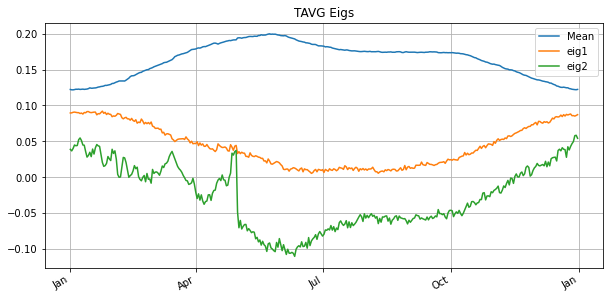

In [5]:
_norm_Mean = Mean / max(Mean) * 0.2 # Combine mean with Eigvecs and scale to similar range.
A = [_norm_Mean] + [EigVec[:,i] for i in range(EigVec.shape[1])]
Combined = np.stack(A).transpose()
fig, axes = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5)); 

YearPlotter().plot(Combined, fig, axes, title=meas+' Eigs', labels=['Mean'] + ['eig'+str(i+1) for i in range(k)])

### Problem 1: Plot percentage of variance explained

Given that all the eigenvalues are stored in `eigvals`, plot the percentage of the variance explained by the first 10 eigenvectors. The result graph should look like this:
![Problem 1](prob1.png "Percentage of variance explained")

#### Task:

Calculate the numpy array `cumvar_10`.The element of `cumvar_10` on index $i$ is the percentage of the variance explained by the first $i$ eigenvectors. Note that each value in `cumvar_10` should be a value from 0 to 100. Check the correctness of your solution by comparing your graph with the graph shown above. 

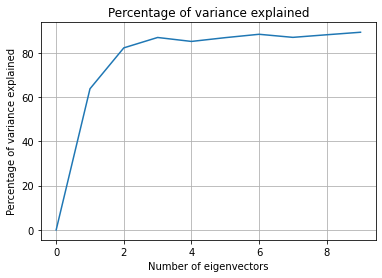

In [6]:
eigvals = STAT[meas]['eigval']

# YOUR CODE HERE
eigvals /= sum(eigvals)
cumvar = np.cumsum(eigvals)
cumvar = 100*np.insert(cumvar,0,0)
cumvar_10 = cumvar[:10]
# YOUR CODE ENDS

cumvar_10 = np.array(cumvar_10)
fig,ax=plt.subplots(1,1);
ax.plot(cumvar_10); 
ax.grid(); 
ax.set_ylabel('Percentage of variance explained')
ax.set_xlabel('Number of eigenvectors')
ax.set_title('Percentage of variance explained');

In [7]:
## Hidden test cases here

Here we construct a Spark DataFrame `df2`, in which each row is a TAVG measurement from a weather station in India. We will be focusing on these columns of `df2` in this notebook:

- `Values`: the TAVG temperature measurement, which is a list of the average temperatures for 366 days in a year (encoded in a byte array).
- `coeff_[i]`: the projection coefficient in front of the `[i]`th eigenvector in the eigen-decomposition of `Values`.
- `res_[i]`: the normalized residual norm of the approximation using the top `[i]` eigenvector.
- `Station`: the id of the station from which the measurement was collected.
- `latitude`, `longitude`: the latitude and longitude of the station.

In [8]:
Query="""
select *
from weather
WHERE country='%s' and measurement='%s'
""" % (country, meas)
df = sqlContext.sql(Query)

df2 = decompose_dataframe(sqlContext, df, EigVec, Mean).cache()
df2.show(2)

+-----------+-----------+--------------------+----+------------------+-----------------+-------+----------+---------+--------+---------+-------------+------------------+-------------------+--------------------+-----+---------+
|Measurement|    Station|              Values|Year|           coeff_1|          coeff_2|country|dist2coast|elevation|latitude|longitude|         name|             res_1|              res_2|            res_mean|state|total_var|
+-----------+-----------+--------------------+----+------------------+-----------------+-------+----------+---------+--------+---------+-------------+------------------+-------------------+--------------------+-----+---------+
|       TAVG|IN001020700|[F6 00 F3 00 EB 0...|2022| 311.8190255200082| 74.9343199727578|  India|     266.0|    364.0|  14.583|   77.633|PBO ANANTAPUR|0.2743575966015028| 0.2504735351188108|0.027627345839496005|     |7081450.0|
|       TAVG|IN001111200|[FE 00 FA 00 F4 0...|2022|268.78238752933265|74.78839208674127|  In

Then we will study what information `coeff_1` and `coeff_2` can tell us.

For each coefficient, 

1. We first filter out the rows where the approximation residuals are too large.
1. Then we sort the rows according to the coefficient values in the increasing order.
1. Last we plot the rows that have lowest and highest coefficient values. 

Each figure below plots the approximations of each measurement (each row in `df2`). 

- `mean`: the `Mean` variable.
- `target`: the `Values` feild of the measurement. 
- `approx [i]`: the approximation using the first `[i]` eigenvectors. 
- `c[i]`, `r[i]`: the values of `coeff_[i]`, `res_[i]`.

In [9]:
# Filter and sort according to coeff_1
coeff1_rows = df2.filter(df2.res_1 < 0.3).sort(df2.coeff_1).collect()

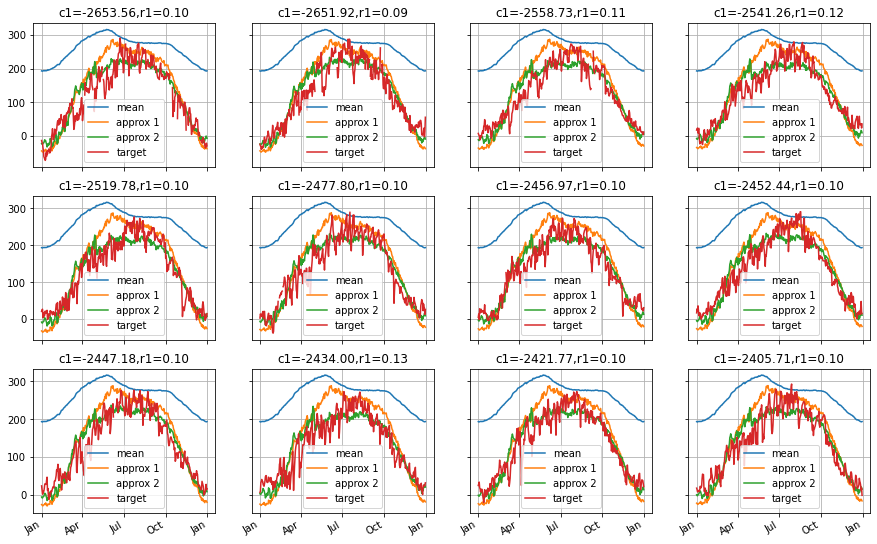

In [10]:
# Measurements with lowest 12 coeff_1
plot_recon_grid(coeff1_rows[0:12], Mean, EigVec, header='c1=%3.2f,r1=%3.2f', params=('coeff_1','res_1'))

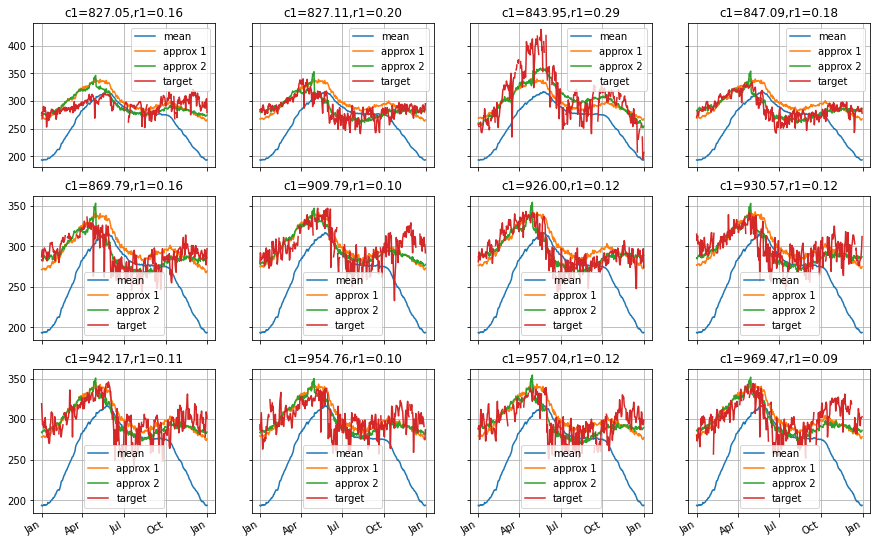

In [11]:
# Measurements with highest 12 coeff_1
plot_recon_grid(coeff1_rows[-12:], Mean, EigVec, header='c1=%3.2f,r1=%3.2f', params=('coeff_1','res_1'))

In [12]:
# Filter and sort according to coeff_2
coeff2_rows = df2.filter(df2.res_2 < 0.11).filter(df2.res_1 > 0.2).sort(df2.coeff_2).collect()

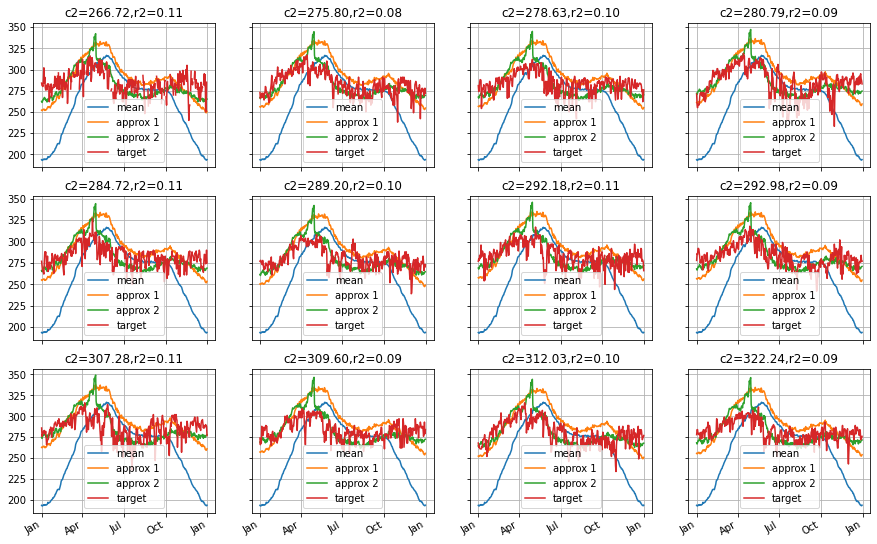

In [13]:
# Measurements with lowest 12 coeff_2
plot_recon_grid(coeff2_rows[0:12], Mean, EigVec, header='c2=%3.2f,r2=%3.2f',params=('coeff_2','res_2'))

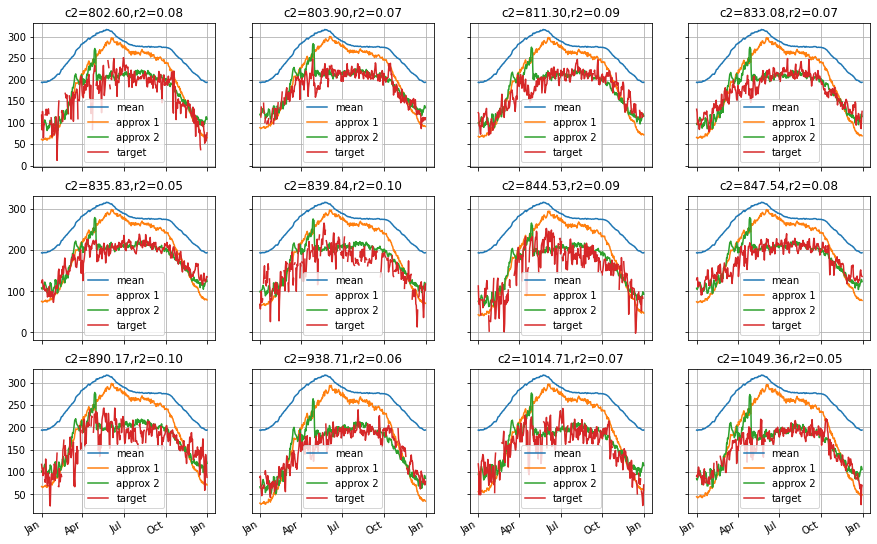

In [14]:
# Measurements with highest 12 coeff_2
plot_recon_grid(coeff2_rows[-12:], Mean, EigVec, header='c2=%3.2f,r2=%3.2f',params=('coeff_2','res_2'))

Instead of plotting the measurements with lowest and highest coefficients, we can just visualize any measurement and its approximations in an interactive plot, where the different approximations can be seen by manually changing the projection coefficients.

In [15]:
# Here we select the measurement (row) with highest `coeff_2`.
row = coeff2_rows[-1]

target = np.array(unpackArray(row.Values,np.int16), dtype=np.float64)
eigen_decomp = Eigen_decomp(None, target, Mean, EigVec)
total_var, residuals,coeff = eigen_decomp.compute_var_explained()
res = residuals[1]
print('residual normalized norm  after mean:', res[0])
print('residual normalized norm  after mean + top eigs:', res[:])

plotter = recon_plot(eigen_decomp,year_axis = True,interactive = True)
display(plotter.get_Interactive())

residual normalized norm  after mean: 0.4880758011556696
residual normalized norm  after mean + top eigs: [0.4880758  0.30144218 0.05103543]


## Part 2: Partitioning the `coeff_1`, `coeff_2` plane 

If we view `coeff_1` as the x-axis and `coeff_2` as the y-axis, we can find that the distribution of the coefficients of the first 2 eigenvectors in `df2` shows some clusters. In this section, we will analyze the coefficients by grouping them toghether.

First, we define 7 clusters and manually choose the centers of for these clusters. In each center, the first element defines the center for `coeff_1` and the second element defines the center for `coeff_2`. 

In [16]:
centers = {
    '0': (0, 0),
    '1': (-250, -250),
    '2': (500, 0),
    '3': (500, 400),
    '4': (-100, 600),
    '5': (-1500, 500),
    '6': (-200, 100)
}

C = []
for key in centers:     
    C.append(centers[key])
C = stack(C)

### Problem 2

Here we are doing several things that are useful later:

1. Convert `df2` to `df3` by grouping the measurements that are from the same `Station`. Each row of `df3` is a station with its `Station`, `Longitude`, `Latitude` and average values of `coeff_1`, `coeff_2` of the measurements from the station.
1. Count the number of measurements for each `Station` and store the results in `station_counts`.
1. Get `pdf` by merging (join) `df3` and `station_counts` on column `Station`.

Note `pdf` is a pandas DataFrame instead of Spark DataFrame to allow less constrained queries.

#### Task:

Write the code that converts `df2` to `df3` (first point above). 
- The `coeff_1` and `coeff_2` columns are grouped by taking the average.
- The `Longitude` and `Latitude` columns are grouped by taking the average or selecting any of them, since the same `Station` will have the same `Longitude` and `Latitude`.
- The rest of the columns in `df2` are discarded.
- `df3` should have 5 columns: `Station`, `coeff_1`, `coeff_2`, `Longitude`, and `Latitude`. Although your solution doesn't have to have the exact same column names, **you should have the same column order** (1st column is stations, 2nd column and 3rd column are the average coeff_1 and coeff_2 values, and 4th and 5th columns are longitudes and latitudes.) 
- The order of the rows in `df3` doesn't matter.
- You should use Spark DataFrame API instead of pandas DataFrame API for this task.

Hints:
1. Use [`groupBy`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.groupBy.html).

In [17]:
# YOUR CODE HERE
df3 = df2.groupBy('Station').avg('coeff_1','coeff_2','Longitude','Latitude')
# YOUR CODE ENDS

pdf3 = df3.toPandas().sort_values('Station')
station_counts = df2.groupBy('Station').count()
pdf = pdf3.merge(station_counts.toPandas(), on='Station')
print(f'There are in total {pdf.shape[0]} stations')

# Assign shorter names to the columns
pdf.columns=['Station', 'coeff_1', 'coeff_2', 'Longitude', 'Latitude', 'count']
pdf.head()

There are in total 183 stations


,Station,coeff_1,coeff_2,Longitude,Latitude,count
0,IN001020700,501.828895,56.073761,77.633,14.583,52
1,IN001050200,440.247446,-10.410478,82.233,16.950,50
2,IN001080500,269.624439,135.317346,78.470,17.450,54
3,IN001090500,318.556718,-95.619204,79.433,18.767,49
4,IN001111200,428.893895,-43.875230,81.150,16.200,50


In [18]:
test = df3.toPandas().sort_values('Station').to_numpy()
answer = np.array([
    ['IN001020700', 501.8288947351339, 56.073760669096956, 77.63299999999998, 14.583],
    ['IN001050200', 440.2474457975864, -10.410478399340107, 82.23299999999999, 16.95],
    ['IN001080500', 269.6244393741326, 135.31734576445672, 78.46999999999997, 17.450000000000006],
    ['IN001090500', 318.55671843948204, -95.6192036324071, 79.433, 18.767000000000003],
    ['IN001111200', 428.89389515464353, -43.875230463056795, 81.15000000000002, 16.200000000000003]
])
assert test.shape == (183, 5)
assert (test[:5, 0] == answer[:5, 0]).all(), 'Your answer is not correct'
assert np.isclose(test[:5, 1:].astype(float), answer[:5, 1:].astype(float), rtol=0, atol=1e-1).all(), 'Your answer is not correct'

In [19]:
## Hidden test cases here

### Problem 3

In this cell, we want to group the stations to their closest center that we defined eariler and add their groups to `pdf` DataFrame.

#### Task:

Given `coeffs`, in which each row contains the `(coeff_1, coeff_2)` of each station, find the index of centers in numpy array `C` that is closest (minimum euclidean distance) to the `(coeff_1, coeff_2)` of each station. Store the results in variable `group`, in which the value in index `i` is the index of the nearest center for `Station i` in `pdf`. 

Hints:
1. Use [`cdist`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html) to calculate the euclidean distance.
1. The best implementation should have only 2 lines of code. 
    1. Calculate the euclidean distances.
    1. Select the center with the minimized euclidean distance for each station.

In [20]:
from scipy.spatial.distance import cdist

coeffs = np.array(pdf[['coeff_1','coeff_2']])

# YOUR CODE HERE
distances = cdist(coeffs,C)
group = [np.argmin(arr) for arr in distances]
# YOUR CODE ENDS

pdf['group'] = group
pdf.head()

,Station,coeff_1,coeff_2,Longitude,Latitude,count,group
0,IN001020700,501.828895,56.073761,77.633,14.583,52,2
1,IN001050200,440.247446,-10.410478,82.233,16.950,50,2
2,IN001080500,269.624439,135.317346,78.470,17.450,54,2
3,IN001090500,318.556718,-95.619204,79.433,18.767,49,2
4,IN001111200,428.893895,-43.875230,81.150,16.200,50,2


In [21]:
answer = array([
    2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 6, 0, 6, 6, 0, 0, 6, 6, 6, 6, 6,
])

assert (group[:22] == answer).all(), 'Your answer for the first 22 stations is not correct'

In [22]:
answer = array([
    0, 0, 3, 2, 3, 1, 1
])

assert (group[-7:] == answer).all(), 'Your answer for the last 7 stations is not correct'

In [23]:
## Hidden test cases here

### Problem 4

Below (after 2 cells) is a scatter plot of the average two first coefficients for each station. 
- The size of the dot indicates the number of measurements of the station (`count` column). 
- The color indicates the group to which the station belongs, which is determined by the index of the closest center.
    - 0: 'red', 1: 'orange', 2: 'yellow', 3: 'green', 4: 'grey', 5: 'blue', 6: 'purple'
- The numbers in text are the group numbers, which are positioned in the cluster center. 

#### Task:

Follow the steps described below to use `pdf` to draw the plot shown above.
1. Use [`pandas.DataFrame.plot.scatter`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.scatter.html?highlight=example) to draw the scatters.
    - You need to figure out how to call this function and what parameters you need pass for arguments `x`, `y` and `s`. 
    - **Use `c=pdf.group.map(lambda x: cmap[x])` and `figsize=[15, 10]` as the parameters when calling this function to match the scatter colors and figure size.** 
1. Use [`matplotlib.pyplot.text`](https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.text.html), which is already loaded as `text` function, and cluster centers `C` to draw the group number texts.
    - You need to figure out how to call this function, what parameters you need pass for arguments `x`, `y` and `s`, and how many times it is needed to be called.
    - **Use `color='black'` and `size=20` as the parameters when calling this function to match the text colors and text size.**
    
Your solution will be graded on whether your output plot is the same as the one shown above.

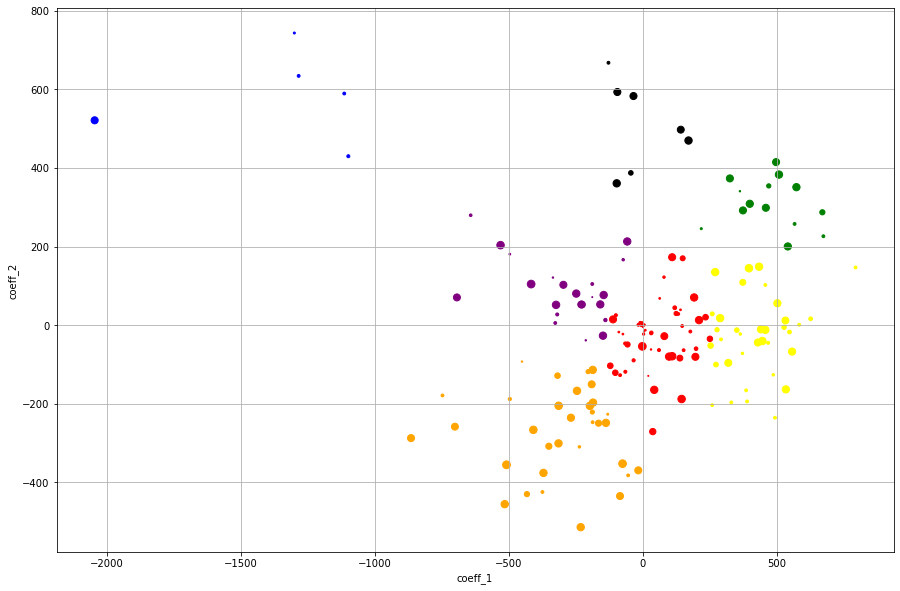

In [24]:
cmap = ['red', 'orange', 'yellow', 'green', 'black', 'blue', 'purple']

# YOUR CODE HERE
pdf.plot.scatter(x='coeff_1',y='coeff_2', s='count', c=pdf.group.map(lambda x: cmap[x]), figsize=[15, 10])
# YOUR CODE ENDS

grid()

![Problem 4](prob4.png "Clusters of coeff_1 and coeff_2")

## Part 3: Visualizing the stations on the map

In this section, we will use [`ipyleaflet`](https://ipyleaflet.readthedocs.io/en/latest/index.html) to visualize the data of `pdf` on an interactive map. 

### Problem 5

Below (after 2 cells) you can see a screenshot of the map where the each circle represents a station. 
- Again the color and the size of the cirlces represent the number of measurements from the station and the group that the station belongs to. 
- The blue rectangle defines the boundary of the stations appeared in the map.
- Note: the coordinate system used in the map is (latitude, longtitude).


#### Task:

Follow the instructions in the comment below and fill in the blanks (`YOUR CODE HERE`) of the cell to recreate this map. 

1. Step 1:
    1. Find the bounding box of the longtitude and latitude in the `pdf` DataFrame
    2. Find the center `(latitude, longtitude)` of the bounding box and store it in the `center` variable.
1. Step 2 (provided in the starter code):
    1. Construct the ipyleaflet `Map` object
1. Step 3:
    1. Construct the blue `Rectangle` object as the bounding box and add it to the map. 
        - You only need to use the `bounds` and `fill_opacity` parameters of `Rectangle`.
1. Step 4:
    1. For each row of the `pdf` DataFrame, add a `Circle` object to represent a station to the map. 
    Here are the instructions for the parameters of `Circle`.
        - Use `weight=1`,`opacity=0.7`, and `fill_opacity=0.7`.
        - Use $4800 \times \sqrt{count}$ for `radius`, where $count$ is the `count` of the station. 
        You might want to convert the result to an integer.
        - Use the list `cmap` and the group that the station belongs to determine the color for `fill_color` and `color`.
        - You need to figure out what is the value for `location` and you don't have to use other parameters.
1. Step 5 (provided in the starter code):
    1. Show the map


Hints:

1. You can adapt the codes from this [notebook](https://github.com/UCSD-Data-Science/Public-CSE255-2022/blob/master/notebooks/Section2-PCA/PCA/5.%20maps%20using%20iPyLeaflet.ipynb).
1. Useful `ipyleaflet` APIs (note that the parameter documentation of the class that you are looking for might appear in its superclass): 
    - [Rectangle](https://ipyleaflet.readthedocs.io/en/latest/_modules/ipyleaflet/leaflet.html#Rectangle)
    - [Circle](https://ipyleaflet.readthedocs.io/en/latest/_modules/ipyleaflet/leaflet.html#Circle)
    
Your solution will be graded on whether your output plot is the same as the one shown above.

In [25]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl,
    basemaps, basemap_to_tiles
)

# Step 1
# YOUR CODE HERE
max_long=pdf['Longitude'].max()
min_long=pdf['Longitude'].min()
max_lat=pdf['Latitude'].max()
min_lat=pdf['Latitude'].min()
center=[(max_lat+min_lat)/2, (max_long+min_long)/2]
# YOUR CODE ENDS

# Step 2
zoom = 5
m = Map(basemap=basemaps.OpenStreetMap.HOT, default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

# Step 3
# YOUR CODE HERE
r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], fill_opacity=0.0)
m += r
# YOUR CODE ENDS

# Step 4
# YOUR CODE HERE
for index,row in pdf.iterrows():
    _lat=row['Latitude']
    _long=row['Longitude']
    _count=row['count']
    _group=row['group']
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(4800*np.sqrt(_count+0.0)), weight=1,
            color=cmap[_group], opacity=0.7, fill_opacity=0.7,
            fill_color=cmap[_group])
    m.add_layer(c)
    
# YOUR CODE ENDS

# Step 5
m    

Map(center=[21.083, 82.23349999999999], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_ti…

![Problem 5](prob5.png "Map")

## Part 4: Yearly temperature profile

Lastly, we want to plot the average TAVG measurements of each group as the function of the days in a year. To do this, we first need to construct a pandas DataFrame `profile` from `df2` that only has stations, decoded temperature values, and the group that the station belongs to. Note that each row in `profile` is a measurement, so the names in `Stations` column are not unique.

In [26]:
full_data = df2.rdd.map(lambda x: (x.Station, x.Year, unpackAndScale(x))).collect()
profile = pd.DataFrame({'Station':[f[0] for f in full_data], 'Values':[f[2] for f in full_data]})
profile = profile.merge(pdf[['Station', 'group']], on='Station')
profile.head()

,Station,Values,group
0,IN001020700,"[246.0, 243.0, 235.0, 226.0, 219.0, 236.0, 251...",2
1,IN001020700,"[275.0, 268.0, 272.0, 281.0, 285.0, 276.0, 271...",2
2,IN001020700,"[247.0, 251.0, 253.0, 230.0, 240.0, 226.0, 231...",2
3,IN001020700,"[258.0, 264.0, 265.0, 267.0, 260.0, 243.0, 257...",2
4,IN001020700,"[241.0, 258.0, 244.0, 248.0, 251.0, 243.0, 250...",2


Then we use data in `profile` DataFrame to plot the yearly temperature profiles (the average TAVG measurements of each group as the funciton of the days in a year). Here we hide the codes that we used to generate the profile graph on purpose, but the profile graph is shown below.
- We can see 7 waveforms in the graph, each of which corresponds to the yearly temperature profile of a group.
- Note that the colors used in the scatterplot/map and the profiles do **not** match.

![Problem 6](prob6.png "Profile")

In [27]:
## The hidden code to generate the profile graph. You can ignore this cell.

### Problem 6

The following problem summerizes this homework. You are asked to relate different characterization of the same group. To answer this question, you might want to go back to the visulization tool earlier in the notebook. 

In this notebook, we have characterized the clusters (groups) of the stations in 3 aspects: 
1. [A cluster in the scatterplot](#Problem-4).
    - group 0: 'red'
    - group 1: 'orange'
    - group 2: 'yellow'
    - group 3: 'green'
    - group 4: 'grey'
    - group 5: 'blue'
    - group 6: 'purple'
1. [A geographical description of a region in India](#Part-3:-Visualizing-the-stations-on-the-map) (One region is not described on purpose).
    - region A: Southern west coast
    - region B: Southern east coast
    - region C: New Delhi Area
    - region D: The area around Rajkot/Jamnagar
    - region E: Along the Brahmaputra river between Dibrugarh and Guwahati
    - region F: Mountain range at the south-west, between Bengaluru and Belagavi
1. [A yearly temperature profile](#Part-4:-Yearly-temperature-profile).
    - waveform a
    - waveform b
    - waveform c
    - waveform d
    - waveform e
    - waveform f
    - waveform g

#### Task:

Figure out 6 tuples of the form `(group, region, waveform)`, where the group, region, and waveform in each tuple are charactering the same cluster (group). That is, figure out which `group` and which `waveform` each `region` corresponds to. Put your answers in 2 dictionaries below where the key is the `region` in uppercase letter and value is your answer (number for `group` and lowercase letter for `waveform`). 

For example, the template provided in the cell below says that `(group 0, region 'A', waveform 'a')` are characterzing the same cluster (group), `(group 1, region 'B', waveform 'b')` are characterzing another cluster (group), and so on.

Hints:
1. First figure out the relations between the groups in the scatterplot and the geographical descriptions.
    1. Find out the area on the `ipyleaflet` map based on the description.
    1. An area corresponds to a group in the scatterplot if they share the same color.
1. There are several ways that you can do to figure out which group each waveform of the yearly temperature profiles corresponds to.
    1. Plot the yearly temperature profile by yourself for each group using `profile` DataFrame and compare the shapes of waveforms in your plot and in the plot we showed.
    1. Decompose the yearly temperature profile vectors to get the first 2 coefficients. See where the coefficients are in the scatterplot and which group the coefficients are near to.

In [28]:
# YOUR CODE HERE
group_answer = {'A': 3, 'B': 2, 'C': 1, 'D': 0, 'E': 6, 'F': 4}
waveform_answer = {'A': 'e', 'B': 'd', 'C': 'g', 'D': 'c', 'E': 'f', 'F': 'a'}
# YOUR CODE ENDS

In [29]:
assert len(group_answer) == 6, 'group_answer should only have 6 keys/values'
assert len(waveform_answer) == 6, 'waveform_answer should only have 6 keys/values'

for region in ['A', 'B', 'C', 'D', 'E', 'F']:
    assert region in group_answer, f'Your group_answer is missing region {region}'
for region in ['A', 'B', 'C', 'D', 'E', 'F']:
    assert region in waveform_answer, f'Your waveform_answer is missing region {region}'

unique_group_answer = np.unique(list(group_answer.values()), return_counts=True)
unique_waveform_answer = np.unique(list(waveform_answer.values()), return_counts=True)
assert (unique_group_answer[1] == 1).all(), 'Your group_answer contains duplicate answers'
assert (unique_waveform_answer[1] == 1).all(), 'Your waveform_answer contains duplicate answers'

In [30]:
## Hidden test cases here

In [31]:
## Hidden test cases here

In [32]:
## Hidden test cases here

In [33]:
## Hidden test cases here

In [34]:
## Hidden test cases here

In [35]:
## Hidden test cases here

In [36]:
## Hidden test cases here

In [37]:
## Hidden test cases here

In [38]:
## Hidden test cases here

In [39]:
## Hidden test cases here

In [40]:
## Hidden test cases here

In [41]:
## Hidden test cases here